# Lab 06: hypothesis testing
CCNY EAS 42000/A4200, Fall 2025, 2025/11/05, Prof. Spencer Hill

**SUMMARY**: We examine the assumptions underlying t tests.

# Preliminaries

## Import needed python packages

In [24]:
from matplotlib import pyplot as plt  # for plotting
import numpy as np # for working with arrays of numerical values
import pandas as pd # for reading CSV or excel files and subsequent analyses
import scipy  # for various scientific calculations
import xarray as xr  # for loading data and subsequent analyses

## Load the Central Park data into this python session

:::{admonition} Explanation of data downloading logic (if you're interested)
:class: dropdown
To make these Jupyter notebooks work when launched to Google Colab---which you can do by clicking the "rocket" icon in the top right from the rendered version of this page on the web---we need some logic that downloads the data.

While we're at it, we use the file's "hash" to check that it has not been altered or corrupted from its original version.  We do this whether or not you've downloaded the file, since it's possible to (accidentally) modify the netCDF file on disk after you downloaded it.

In the rendered HTML version of the site, this cell is hidden, since otherwise it's a bit distracting.  But you can click on it to reveal its content.

If you're in a Google Colab session, you don't need to modify anything in that cell; just run it.  Otherwise, modify the `LOCAL_DATA_DIR` variable defined in the next python cell to point to where the dataset lives on your machine---or where you want it to be downloaded to if you don't have it already.
:::

In [25]:
!pip install pooch

# The above command installs the needed `pooch` 3rd-party package if it's not already installed.


import hashlib  # for verifying that the Central Park file is not corrupted
import pathlib  # for constructing paths to the dataset's location on disk
import sys  # for checking if this is a Google Colab session or not
import pooch  # for downloading the dataset from the web, if needed


# Replace "../data" as needed to point to the correct directory for you.
# This can be an *absolute path* or a *relative path*.  One dot, `.`, means
# "this directory", while two dots, `..`, means "go up one directory."
LOCAL_DATA_DIR = "../data"  # If you're in Colab: just ignore this.

# The URL where the dataset can be downloaded from.
DATA_URL = (
    "https://spencerahill.github.io/25f-stat-methods-course/_downloads/"
    "91803b82950d49961a65355c075439b3/central-park-station-data_1869-01-01_2023-09-30.nc"
)

# This HASH_HEX stores a "hash" which we use to verify that the data you end up
# with has not been altered or corrupted compared to the one at the above URL.
HASH_HEX = "85237a4bae1202030a36f330764fd5bd0c2c4fa484b3ae34a05db49fe7721eee"


def create_data_path(
    colab_dir="/content/data", 
    local_dir=LOCAL_DATA_DIR,
    filename="central-park-station-data_1869-01-01_2023-09-30.nc",
):
    """Set the path for the data, whether on colab or a local Jupyter session."""
    is_this_a_colab = "google.colab" in sys.modules
    if is_this_a_colab:
        data_dir = colab_dir 
    else: 
        data_dir = local_dir

    DATA_DIR = pathlib.Path(data_dir)
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    return DATA_DIR / filename


def sha256sum(path: pathlib.Path) -> str:
    """Get the hash of the file at the specified path."""
    return hashlib.sha256(path.read_bytes()).hexdigest()


DATA_PATH = create_data_path()
# Determine if we'll need to download the data, which we'll do if either (a) 
# the data can't be found, or (b) it appears corrupted/modified from the
# "master" file at the above URL.
need_fetch = (not DATA_PATH.exists()) or (sha256sum(DATA_PATH) != HASH_HEX)

# Download the data if needed.
if need_fetch:
    fetched_data = pooch.retrieve(
        url=DATA_URL, 
        known_hash=f"sha256:{HASH_HEX}",
        path=DATA_PATH.parents[0], 
        fname=DATA_PATH.name,
    )
    print(f"\nDownloaded and verified: {fetched_data}")
else:
    print(f"\nVerified existing file at {DATA_PATH}")

Looking in links: https://pypi.python.org/pypi, https://testpypi.python.org/pypi

Verified existing file at ../data/central-park-station-data_1869-01-01_2023-09-30.nc


In [27]:
import xarray as xr

# `DATA_PATH` variable was created by the hidden cell just above. 
# Un-hide that cell if you want to see the details.
ds_cp = xr.open_dataset(DATA_PATH)
ds_cp

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 56520)
Coordinates:
  * time           (time) datetime64[ns] 452kB 1869-01-01 ... 2023-09-30
Data variables:
    temp_max       (time) int64 452kB ...
    temp_min       (time) int64 452kB ...
    temp_avg       (time) float64 452kB ...
    temp_anom      (time) float64 452kB ...
    heat_deg_days  (time) int64 452kB ...
    cool_deg_days  (time) int64 452kB ...
    precip         (time) float64 452kB ...
    snow_fall      (time) float64 452kB ...
    snow_depth     (time) int64 452kB ...

# Investigating assumptions underlying the t test

## Independence of observations

In [5]:
ann_snow = ds_cp["snow_fall"].groupby("time.year").sum()
snow_1900to1919 = ann_snow.sel(year=slice(1900, 1919))
snow_2000to2019 = ann_snow.sel(year=slice(2000, 2019))

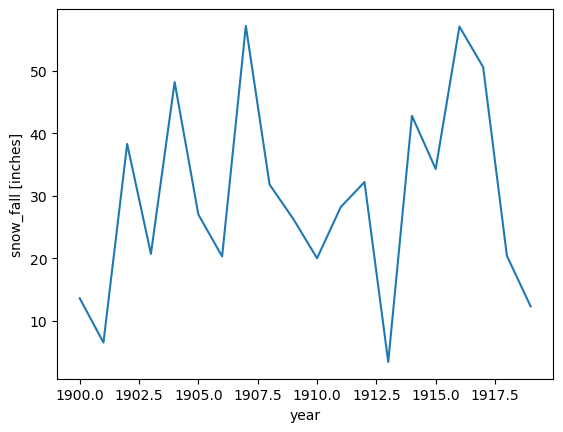

In [28]:
snow_1900to1919.plot()

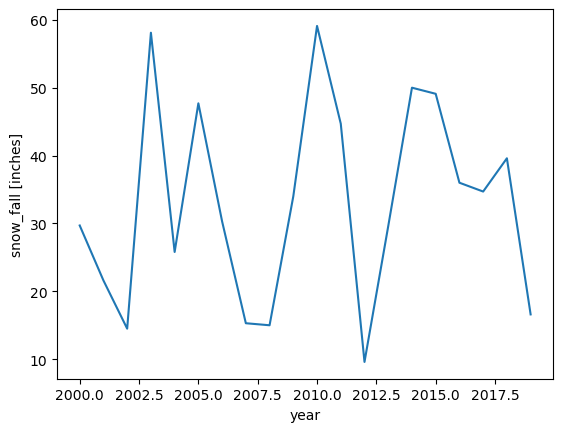

In [29]:
snow_2000to2019.plot()

By eye, the year to year variations in the annual snowfall do not look strongly serially correlated.  We can be more quantitative about that via the **autocorrelation function (ACF)**

In [30]:
from statsmodels.tsa.stattools import acf

In [32]:
acf_1900_1919 = acf(snow_1900to1919, fft=False, nlags=len(snow_1900to1919) - 1)

Text(0, 0.5, 'ACF (unitless)')

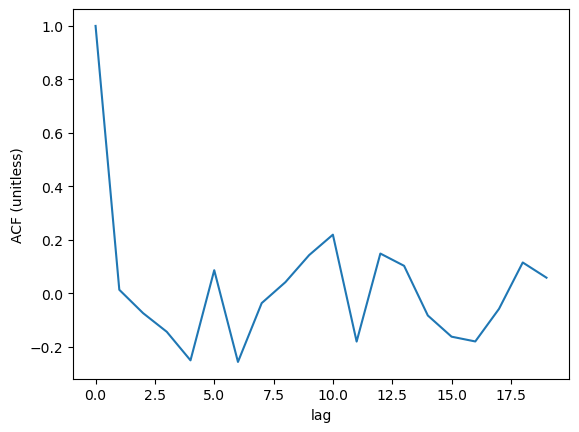

In [34]:
plt.plot(acf_1900_1919)
plt.xlabel("lag")
plt.ylabel("ACF (unitless)")

In [35]:
acf_2000_2019 = acf(snow_2000to2019, fft=False, nlags=len(snow_1900to1919) - 1)

Text(0, 0.5, 'ACF (unitless)')

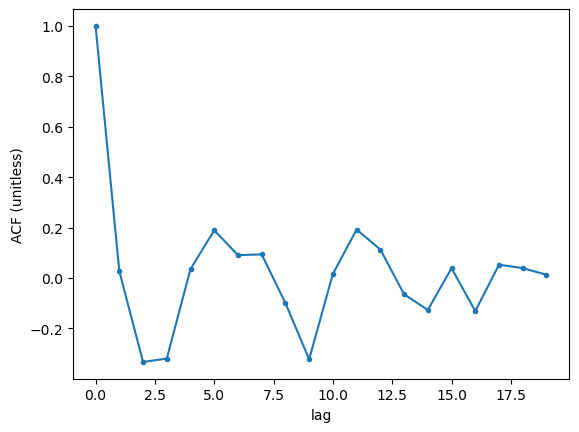

In [37]:
plt.plot(acf_2000_2019, marker=".")
plt.xlabel("lag")
plt.ylabel("ACF (unitless)")

## Both samples are drawn from normal distributions

(array([3., 5., 3., 4., 2., 3.]),
 array([ 3.4       , 12.36666667, 21.33333333, 30.3       , 39.26666667,
        48.23333333, 57.2       ]),
 <BarContainer object of 6 artists>)

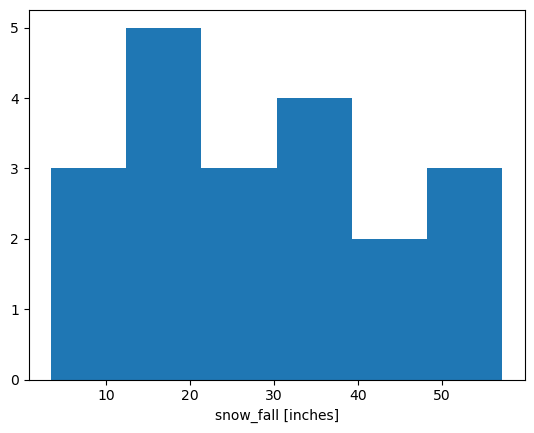

In [38]:
snow_1900to1919.plot.hist(bins=6)

(array([5., 2., 4., 3., 4., 2.]),
 array([ 9.6 , 17.85, 26.1 , 34.35, 42.6 , 50.85, 59.1 ]),
 <BarContainer object of 6 artists>)

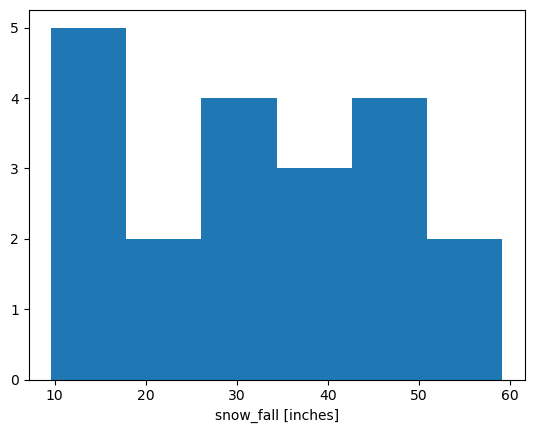

In [39]:
snow_2000to2019.plot.hist(bins=6)

(array([ 7., 22., 23., 23., 30., 18., 12.,  9.,  5.,  6.]),
 array([ 2.3 ,  8.47, 14.64, 20.81, 26.98, 33.15, 39.32, 45.49, 51.66,
        57.83, 64.  ]),
 <BarContainer object of 10 artists>)

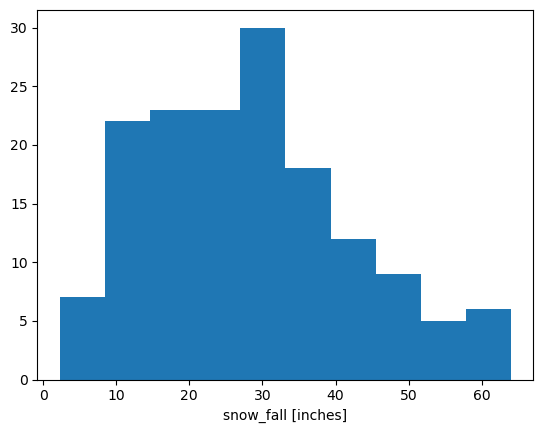

In [40]:
ann_snow.plot.hist()

## Equal variance of the two samples

In [41]:
snow_1900to1919.var()

<xarray.DataArray 'snow_fall' ()> Size: 8B
array(236.3004)

In [42]:
snow_2000to2019.var()

<xarray.DataArray 'snow_fall' ()> Size: 8B
array(213.8205)

Tests for the significance of this difference: f test; Bartlett's test; Levene's test